In [62]:
import pandas as pd
import numpy as np
import yfinance as yf
from scipy import stats
from datetime import datetime, timedelta
import pytz
import pandas_market_calendars as mcal
import alphalens as al
import matplotlib.pyplot as plt

In [63]:
columns_to_load = ['Ticker', 'pubDate', 'sentiment_score']
df = pd.read_csv("transformers_project.csv", usecols=columns_to_load)

In [64]:
display(df)

,Ticker,pubDate,sentiment_score
0,MAR,2022-10-06T09:40:18+00:00,-6.810195e-01
1,DFS,2023-05-05T19:05:15+00:00,9.828509e-01
2,LEN,2023-06-12T10:00:38+00:00,-9.995565e-01
3,BLK,2022-11-10T08:44:48-04:00,-5.641357e-08
4,BKR,2022-10-07T01:45:10+00:00,-9.975823e-01
...,...,...,...
160,SBNY,2023-04-07T21:51:41+00:00,9.610708e-01
161,AAL,2023-07-24T06:30:00+00:00,-1.744942e-01
162,SIVBQ,2023-03-15T11:00:27+00:00,9.272764e-01
163,BAC,2023-03-17T16:03:30+00:00,9.994711e-01


## Data Preprocessing

### Adjusting the dates of news articles

In [65]:
df['pubDate'] = pd.to_datetime(df['pubDate'], errors='coerce')

nyse = mcal.get_calendar('NYSE')

trading_start_hour = 9
trading_start_minute = 30
trading_end_hour = 16
trading_end_minute = 0

def adjust_date(pub_date):
    if pd.isnull(pub_date) or not isinstance(pub_date, pd.Timestamp):
        return pub_date

    trading_end_time = pd.Timestamp(f'{pub_date.date()} {trading_end_hour}:{trading_end_minute}')
    if pub_date >= trading_end_time:
        next_trading_day = nyse.schedule(start_date=pub_date.date() + pd.DateOffset(days=1), end_date=pub_date.date() + pd.DateOffset(days=10)).iloc[0]['market_open']
        return next_trading_day
    else:
        valid_days = nyse.valid_days(start_date=pub_date.date(), end_date=pub_date.date())
        if not valid_days.empty and pub_date.date() == valid_days[0].date():
            return pub_date
        else:
            next_trading_day = nyse.schedule(start_date=pub_date.date() + pd.DateOffset(days=1), end_date=pub_date.date() + pd.DateOffset(days=10)).iloc[0]['market_open']
            return next_trading_day

df['pubDate'] = df['pubDate'].apply(adjust_date)

TypeError: Cannot compare tz-naive and tz-aware timestamps

### Converting probabiltiies to one value

### Replacing tickers

In [66]:
df['pubDate'] = pd.to_datetime(df['pubDate'], utc=True, errors='coerce')
df['pubDate'] = df['pubDate'].dt.date

print(df['pubDate'].dtypes)

replacements = {
    'ATVI': 'ATVIX',
    'ABC': 'ABG',
    'FBHS': '2FB.BE',
    'FISV': 'FISV.VI',
    'FRC': 'FRCB',
    'NLOK': 'SYM.MU',
    'PKI': 'PKN.SG',
    'RE': 'ERE.SG',
    'SIVB': 'SIVBQ',
}

df['Ticker'] = df['Ticker'].replace(replacements)

df = df[df['Ticker'] != 'SBNY'] 
df.head(10)

object


,Ticker,pubDate,sentiment_score
0,MAR,2022-10-06,-6.810195e-01
1,DFS,2023-05-05,9.828509e-01
2,LEN,2023-06-12,-9.995565e-01
3,BLK,2022-11-10,-5.641357e-08
4,BKR,2022-10-07,-9.975823e-01
5,AAPL,2023-04-13,1.675096e-01
6,COP,NaT,-9.997816e-01
7,TSLA,2023-04-17,-9.941927e-01
8,NKE,2022-12-27,-9.998217e-01
9,DFS,2023-03-02,-7.838747e-01


### Filtering the dates (OPTIONAL - Left the percentage at 0 for now)

In [67]:
# df['pubDate'] = pd.to_datetime(df['pubDate'])

# df['pubDate'] = pd.to_datetime(df['pubDate'])
# total_tickers = df['Ticker'].nunique()

# percentage = 0
# threshold = total_tickers * percentage

# df.sort_values('pubDate', inplace=True)

# ticker_counts_by_date = {}

# for date in df['pubDate'].unique():
#     tickers_with_scores = df[df['pubDate'] <= date]['Ticker'].nunique()
#     ticker_counts_by_date[date] = tickers_with_scores

# ticker_counts_df = pd.DataFrame(list(ticker_counts_by_date.items()), columns=['Date', 'TickerCount'])

# earliest_date = ticker_counts_df[ticker_counts_df['TickerCount'] >= threshold]['Date'].min()

# #print(f"Earliest date with sentiment scores for at least {percentage} of the tickers: {earliest_date}")

# df = df[df['pubDate'] >= earliest_date]

### Aggregating scores (Signal) per day

In [68]:
aggregated_data = df.groupby(['Ticker', 'pubDate'])['sentiment_score'].mean().reset_index()
aggregated_data

,Ticker,pubDate,sentiment_score
0,AAL,2023-03-09,0.999254
1,AAL,2023-04-17,-0.999511
2,AAL,2023-07-24,-0.174494
3,AAPL,2023-04-13,0.167510
4,ABG.BE,2022-10-06,-0.681020
...,...,...,...
128,WM,2023-01-22,0.946538
129,WM,2023-06-17,-0.997274
130,WMB,2022-11-23,-0.981128
131,WRK,2023-02-15,-0.999915


### Converting the datatime back to UTC and indexing for alphalens

In [69]:
aggregated_data['pubDate'] = pd.to_datetime(aggregated_data['pubDate']).dt.tz_localize('UTC')

aggregated_data.set_index(['pubDate', 'Ticker'], inplace=True)
aggregated_data

,,sentiment_score
pubDate,Ticker,
2023-03-09 00:00:00+00:00,AAL,0.999254
2023-04-17 00:00:00+00:00,AAL,-0.999511
2023-07-24 00:00:00+00:00,AAL,-0.174494
2023-04-13 00:00:00+00:00,AAPL,0.167510
2022-10-06 00:00:00+00:00,ABG.BE,-0.681020
...,...,...
2023-01-22 00:00:00+00:00,WM,0.946538
2023-06-17 00:00:00+00:00,WM,-0.997274
2022-11-23 00:00:00+00:00,WMB,-0.981128


### Fetching  stock prices for the unique tickers in the dataframe

In [70]:
# tickers = aggregated_data.index.get_level_values('Ticker').unique()
# start_date = aggregated_data.index.get_level_values('pubDate').min()
# end_date = aggregated_data.index.get_level_values('pubDate').max() + pd.Timedelta(days=60) 

# all_days = pd.date_range(start=start_date, end=end_date, freq='D')

# prices = pd.DataFrame()

# for ticker in tickers:
#     ticker_data = yf.download(ticker, start=start_date.strftime('%Y-%m-%d'), end=end_date.strftime('%Y-%m-%d'))['Adj Close']
#     prices[ticker] = ticker_data

# prices.index = pd.to_datetime(prices.index).tz_localize('UTC')

# prices = prices.reindex(all_days)

# prices.ffill(inplace=True)

tickers = aggregated_data.index.get_level_values('Ticker').unique()
start_date = aggregated_data.index.get_level_values('pubDate').min()
end_date = aggregated_data.index.get_level_values('pubDate').max() + pd.Timedelta(days=15)  # Extending for forward return calculation

# Fetching adjusted close prices for all tickers
prices = pd.DataFrame()
for ticker in tickers:
    ticker_data = yf.download(ticker, start=start_date.strftime('%Y-%m-%d'), end=end_date.strftime('%Y-%m-%d'))['Adj Close']
    prices[ticker] = ticker_data

#spy_data = yf.download('SPY', start=start_date.strftime('%Y-%m-%d'), end=end_date.strftime('%Y-%m-%d'))['Adj Close']

# spy_returns = spy_data.pct_change()

#prices['SPY'] = spy_data

prices.index = prices.index.tz_localize('UTC')


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

In [71]:
prices

,AAL,AAPL,ABG.BE,ADBE,AXP,BA,BAC,BAX,BBWI,BKR,...,STLD,T,TMUS,TSLA,TSN,UNH,WM,WMB,WRK,XEL
Date,,,,,,,,,,,,,,,,,,,,,
2022-09-15 00:00:00+00:00,14.27,151.079330,137.108414,309.130005,152.304001,149.779999,33.040653,56.582905,36.182045,23.418913,...,74.225990,14.938560,139.849915,303.750000,68.385376,511.554413,166.792633,30.280178,36.710800,69.718895
2022-09-16 00:00:00+00:00,13.75,149.423477,135.968796,299.500000,149.328720,144.289993,32.667263,55.824886,36.607941,22.908760,...,73.047806,14.920733,138.788773,303.350006,68.300003,509.705627,165.144501,29.228718,32.495430,70.212959
2022-09-19 00:00:00+00:00,14.21,153.171463,136.754730,296.059998,151.552856,144.880005,33.212986,56.064762,37.527500,23.274530,...,75.160751,14.938560,139.542496,309.070007,68.707863,512.180603,166.675613,29.569983,34.274830,70.811516
2022-09-20 00:00:00+00:00,13.97,155.570969,136.538589,291.059998,149.718918,145.940002,32.715130,54.289650,36.346600,22.138720,...,73.855980,14.760294,138.481354,308.730011,68.129288,511.446899,165.495575,29.357845,32.733326,69.813919
2022-09-21 00:00:00+00:00,13.23,152.417923,135.929489,286.299988,145.065811,143.289993,31.738560,53.224586,35.823898,22.157969,...,72.249359,14.483986,135.635178,300.799988,67.645554,500.959686,164.705627,29.025801,31.981594,68.882797
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-15 00:00:00+00:00,13.31,174.556976,163.851059,528.890015,162.052689,208.110001,28.411501,38.498127,35.901390,35.696503,...,97.659088,14.467650,140.752350,274.390015,53.481731,483.140717,159.250107,33.469810,35.966671,56.874058
2023-09-18 00:00:00+00:00,13.11,177.509338,164.746414,532.419983,157.975403,205.119995,28.332689,38.153336,35.713375,35.992661,...,97.065475,14.334659,139.641647,265.279999,52.854149,482.505371,158.605087,33.557529,35.976521,56.893684
2023-09-19 00:00:00+00:00,13.19,178.606491,165.064774,541.690002,157.698318,204.479996,28.224323,38.379910,34.812870,35.716248,...,98.232918,14.448652,141.287872,266.500000,52.775703,477.144867,158.446320,33.421078,36.321121,57.413662


In [72]:
#returns = prices.dropna(axis=1).pct_change()
#returns['AAL'] - returns['SPY']

### Merging missing dates

In [73]:
# Create a dataframe with all ticker-date combinations from prices
all_dates = prices.index
all_tickers_dates = pd.MultiIndex.from_product([tickers, all_dates], names=['Ticker', 'Date'])
all_tickers_dates_df = pd.DataFrame(index=all_tickers_dates).reset_index()

# Merge this with aggregated_data to find missing dates
aggregated_data_reset = aggregated_data.reset_index()
merged_data = pd.merge(all_tickers_dates_df, aggregated_data_reset, how='left', left_on=['Ticker', 'Date'], right_on=['Ticker', 'pubDate'])

merged_data.to_csv("Check.csv")

### Forward filling with a decaying factor

In [74]:
decay_factor = 0.5

# Iterate over each ticker
for ticker in tickers:
    # Select the data for the current ticker
    ticker_data = merged_data[merged_data['Ticker'] == ticker].copy()

    # Identify where NaNs are before forward filling
    original_nans = ticker_data['sentiment_score'].isna()

    # Forward fill the Sentiment_Score within the ticker's data
    ticker_data['sentiment_score'] = ticker_data['sentiment_score'].ffill()

    # Apply decay only to originally NaN values
    for i in range(1, len(ticker_data)):
        # If the current value was originally NaN, apply the decay
        if original_nans.iloc[i]:
            ticker_data.iloc[i, ticker_data.columns.get_loc('sentiment_score')] = ticker_data.iloc[i - 1, ticker_data.columns.get_loc('sentiment_score')] * decay_factor

    # Update the merged_data with the processed data for the current ticker
    merged_data.loc[merged_data['Ticker'] == ticker, 'sentiment_score'] = ticker_data['sentiment_score']

# Fill any remaining NaN values in Sentiment_Score with 0, if necessary
merged_data['sentiment_score'].fillna(0, inplace=True)

In [75]:
merged_data.drop(columns=['pubDate'], inplace=True)
merged_data.set_index(['Date', 'Ticker'], inplace=True)

In [76]:
merged_data

,,sentiment_score
Date,Ticker,
2022-09-15 00:00:00+00:00,AAL,0.000000e+00
2022-09-16 00:00:00+00:00,AAL,0.000000e+00
2022-09-19 00:00:00+00:00,AAL,0.000000e+00
2022-09-20 00:00:00+00:00,AAL,0.000000e+00
2022-09-21 00:00:00+00:00,AAL,0.000000e+00
...,...,...
2023-09-15 00:00:00+00:00,XEL,5.803655e-75
2023-09-18 00:00:00+00:00,XEL,2.901828e-75
2023-09-19 00:00:00+00:00,XEL,1.450914e-75


## Alphalens pipeline

Dropped 72.7% entries from factor data: 3.9% in forward returns computation and 68.8% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 73.0%, not exceeded: OK!
Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1.0,-9.999655e-01,-9.416557e-26,-1.635016e-02,1.022219e-01,1207,21.287478
2.0,-9.259141e-10,-9.374643e-38,-4.906394e-12,4.755260e-11,1103,19.453263
3.0,-1.033887e-25,-1.850119e-68,-4.128015e-28,4.415535e-27,1120,19.753086
4.0,-2.079574e-53,3.115814e-66,-4.710912e-56,7.239766e-55,1168,20.599647
5.0,3.714339e-73,9.600686e-01,4.360901e-03,4.784819e-02,1072,18.906526


Returns Analysis


,1D,5D,10D
Ann. alpha,1.612,1.366,1.438
beta,0.009,0.009,0.325
Mean Period Wise Return Top Quantile (bps),6.652,9.073,12.559
Mean Period Wise Return Bottom Quantile (bps),-13.059,-9.723,-12.435
Mean Period Wise Spread (bps),19.711,18.636,24.573


Information Analysis


,1D,5D,10D
IC Mean,0.001,0.022,0.035
IC Std.,0.123,0.104,0.102
Risk-Adjusted IC,0.012,0.209,0.345
t-stat(IC),0.099,1.748,2.886
p-value(IC),0.921,0.085,0.005
IC Skew,-0.274,0.169,0.567
IC Kurtosis,-0.594,-0.001,-0.616


Turnover Analysis


,1D,5D,10D
Quantile 1 Mean Turnover,0.011,0.046,0.083
Quantile 2 Mean Turnover,0.012,0.049,0.090
Quantile 3 Mean Turnover,0.011,0.048,0.085
Quantile 4 Mean Turnover,0.011,0.047,0.078
Quantile 5 Mean Turnover,0.004,0.018,0.035


,1D,5D,10D
Mean Factor Rank Autocorrelation,0.993,0.969,0.943


<Figure size 640x480 with 0 Axes>

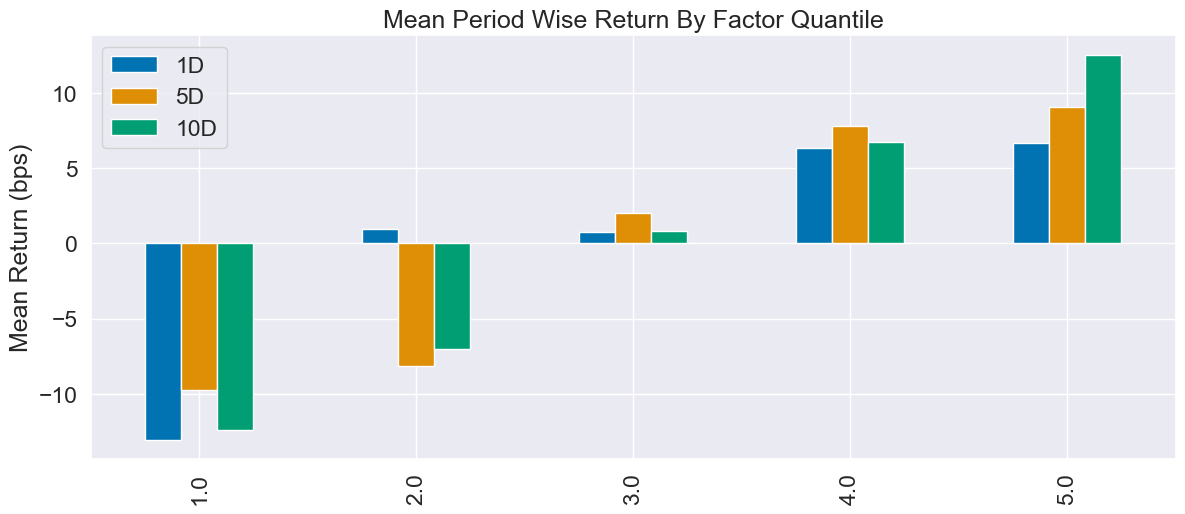

Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1.0,-9.999655e-01,-9.416557e-26,-1.635016e-02,1.022219e-01,1207,21.287478
2.0,-9.259141e-10,-9.374643e-38,-4.906394e-12,4.755260e-11,1103,19.453263
3.0,-1.033887e-25,-1.850119e-68,-4.128015e-28,4.415535e-27,1120,19.753086
4.0,-2.079574e-53,3.115814e-66,-4.710912e-56,7.239766e-55,1168,20.599647
5.0,3.714339e-73,9.600686e-01,4.360901e-03,4.784819e-02,1072,18.906526


Returns Analysis


,1D,5D,10D
Ann. alpha,1.612,1.366,1.438
beta,0.009,0.009,0.325
Mean Period Wise Return Top Quantile (bps),6.652,9.073,12.559
Mean Period Wise Return Bottom Quantile (bps),-13.059,-9.723,-12.435
Mean Period Wise Spread (bps),19.711,18.636,24.573


<Figure size 640x480 with 0 Axes>

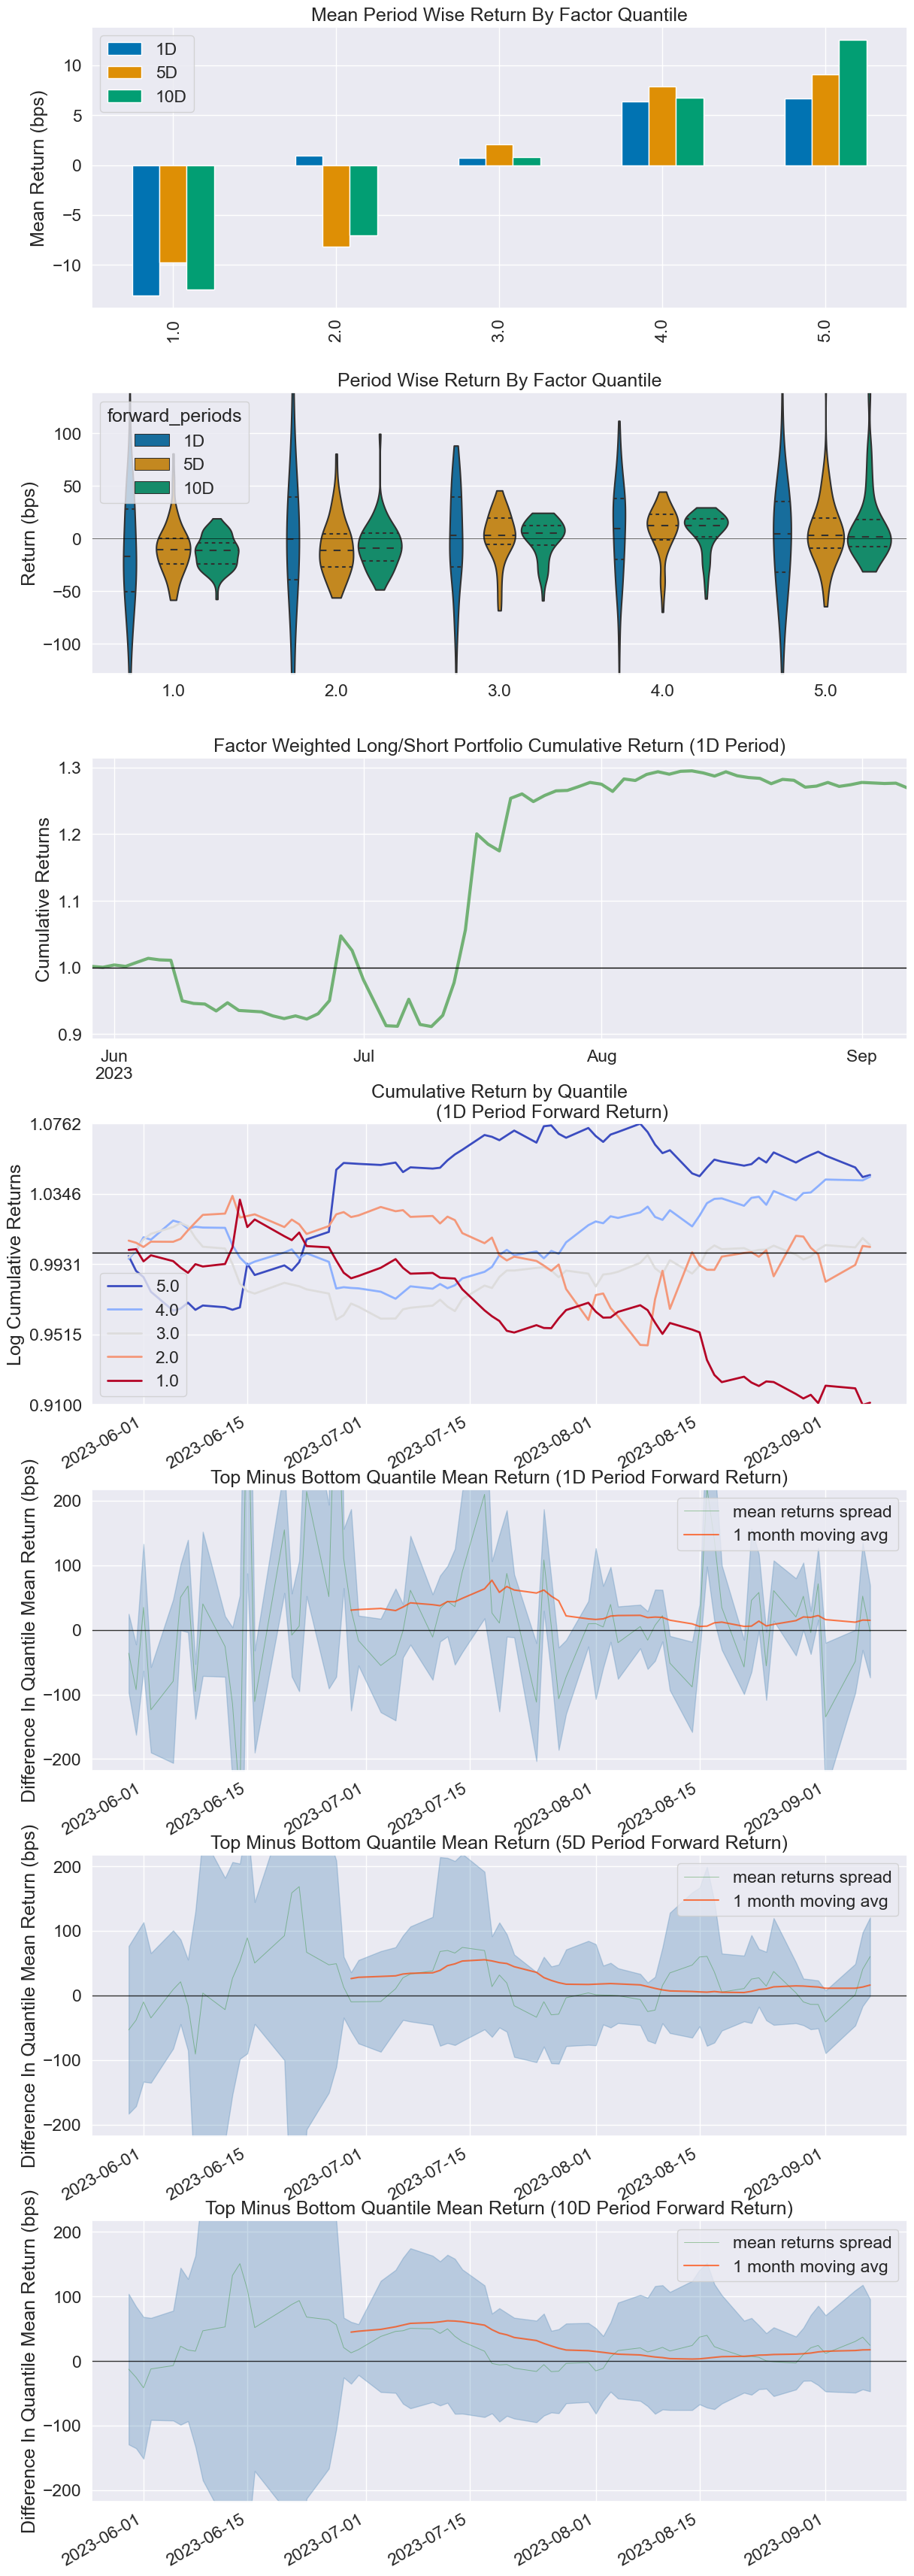

Information Analysis


,1D,5D,10D
IC Mean,0.001,0.022,0.035
IC Std.,0.123,0.104,0.102
Risk-Adjusted IC,0.012,0.209,0.345
t-stat(IC),0.099,1.748,2.886
p-value(IC),0.921,0.085,0.005
IC Skew,-0.274,0.169,0.567
IC Kurtosis,-0.594,-0.001,-0.616


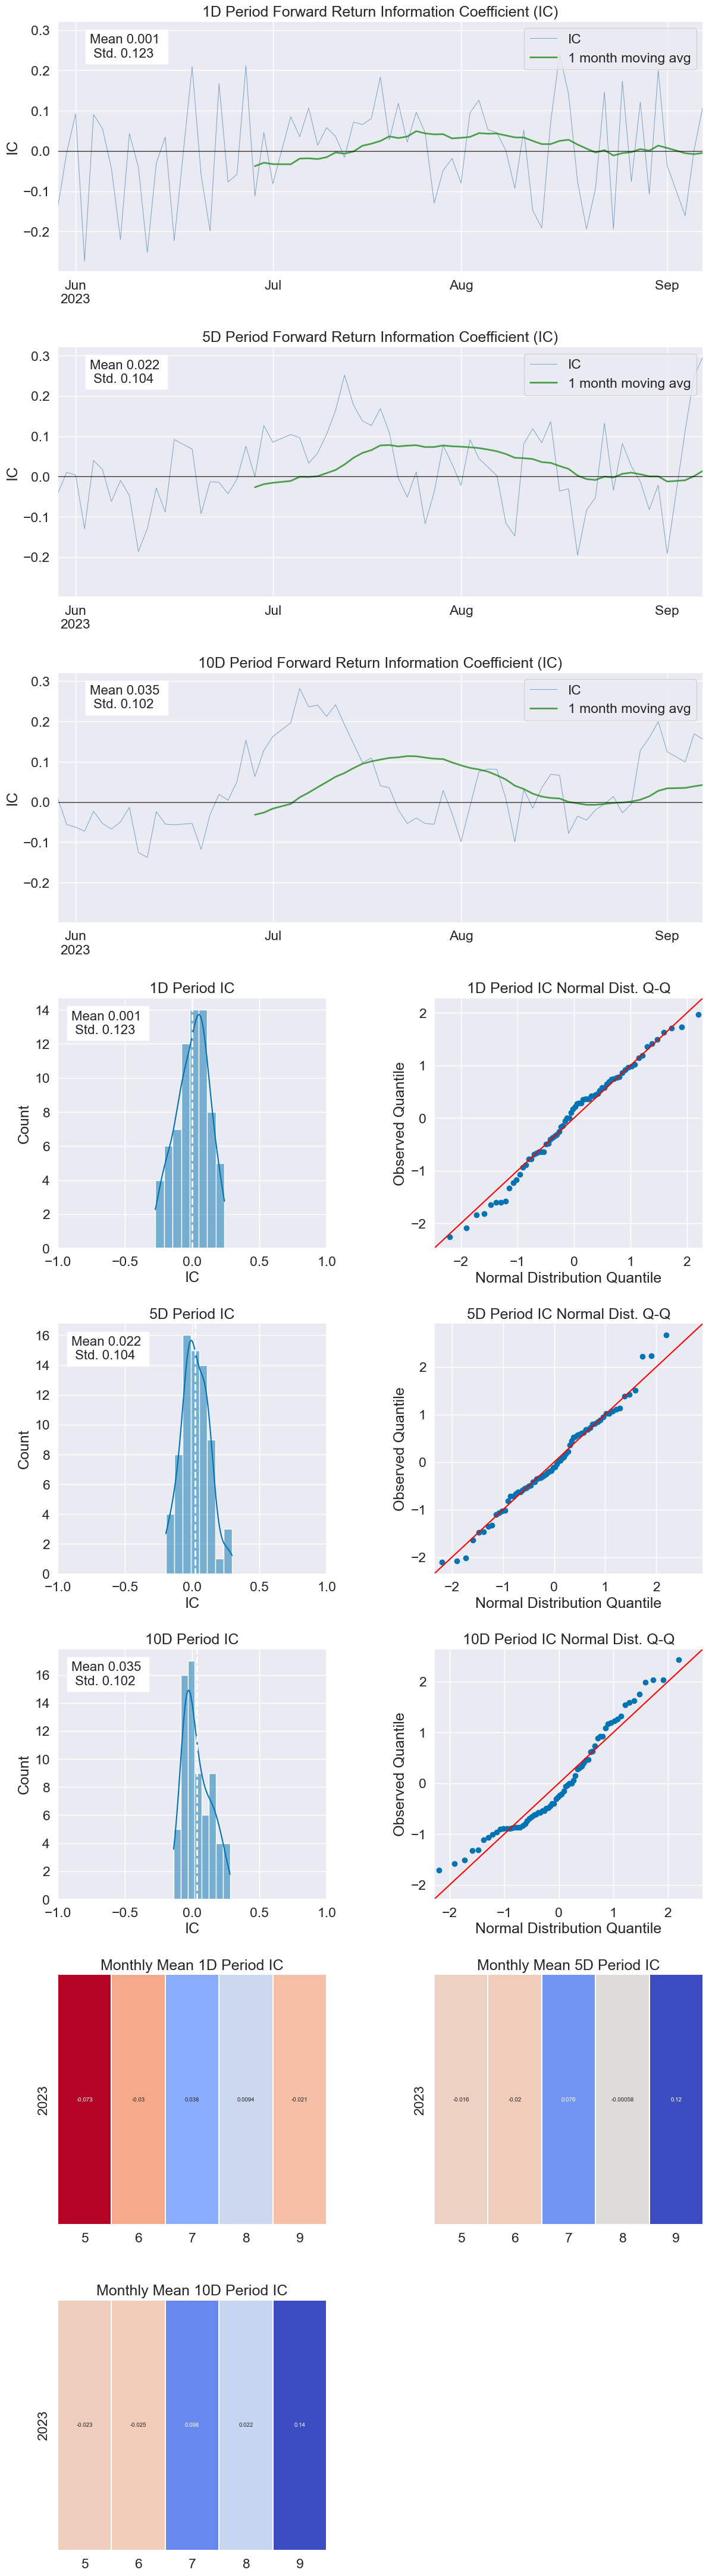

Turnover Analysis


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/alphalens/utils.py:929: UserWarning: Skipping return periods that aren't exact multiples of days.
  warnings.warn(


,1D,5D,10D
Quantile 1.0 Mean Turnover,0.011,0.046,0.083
Quantile 2.0 Mean Turnover,0.012,0.049,0.090
Quantile 3.0 Mean Turnover,0.011,0.048,0.085
Quantile 4.0 Mean Turnover,0.011,0.047,0.078
Quantile 5.0 Mean Turnover,0.004,0.018,0.035


,1D,5D,10D
Mean Factor Rank Autocorrelation,0.993,0.969,0.943


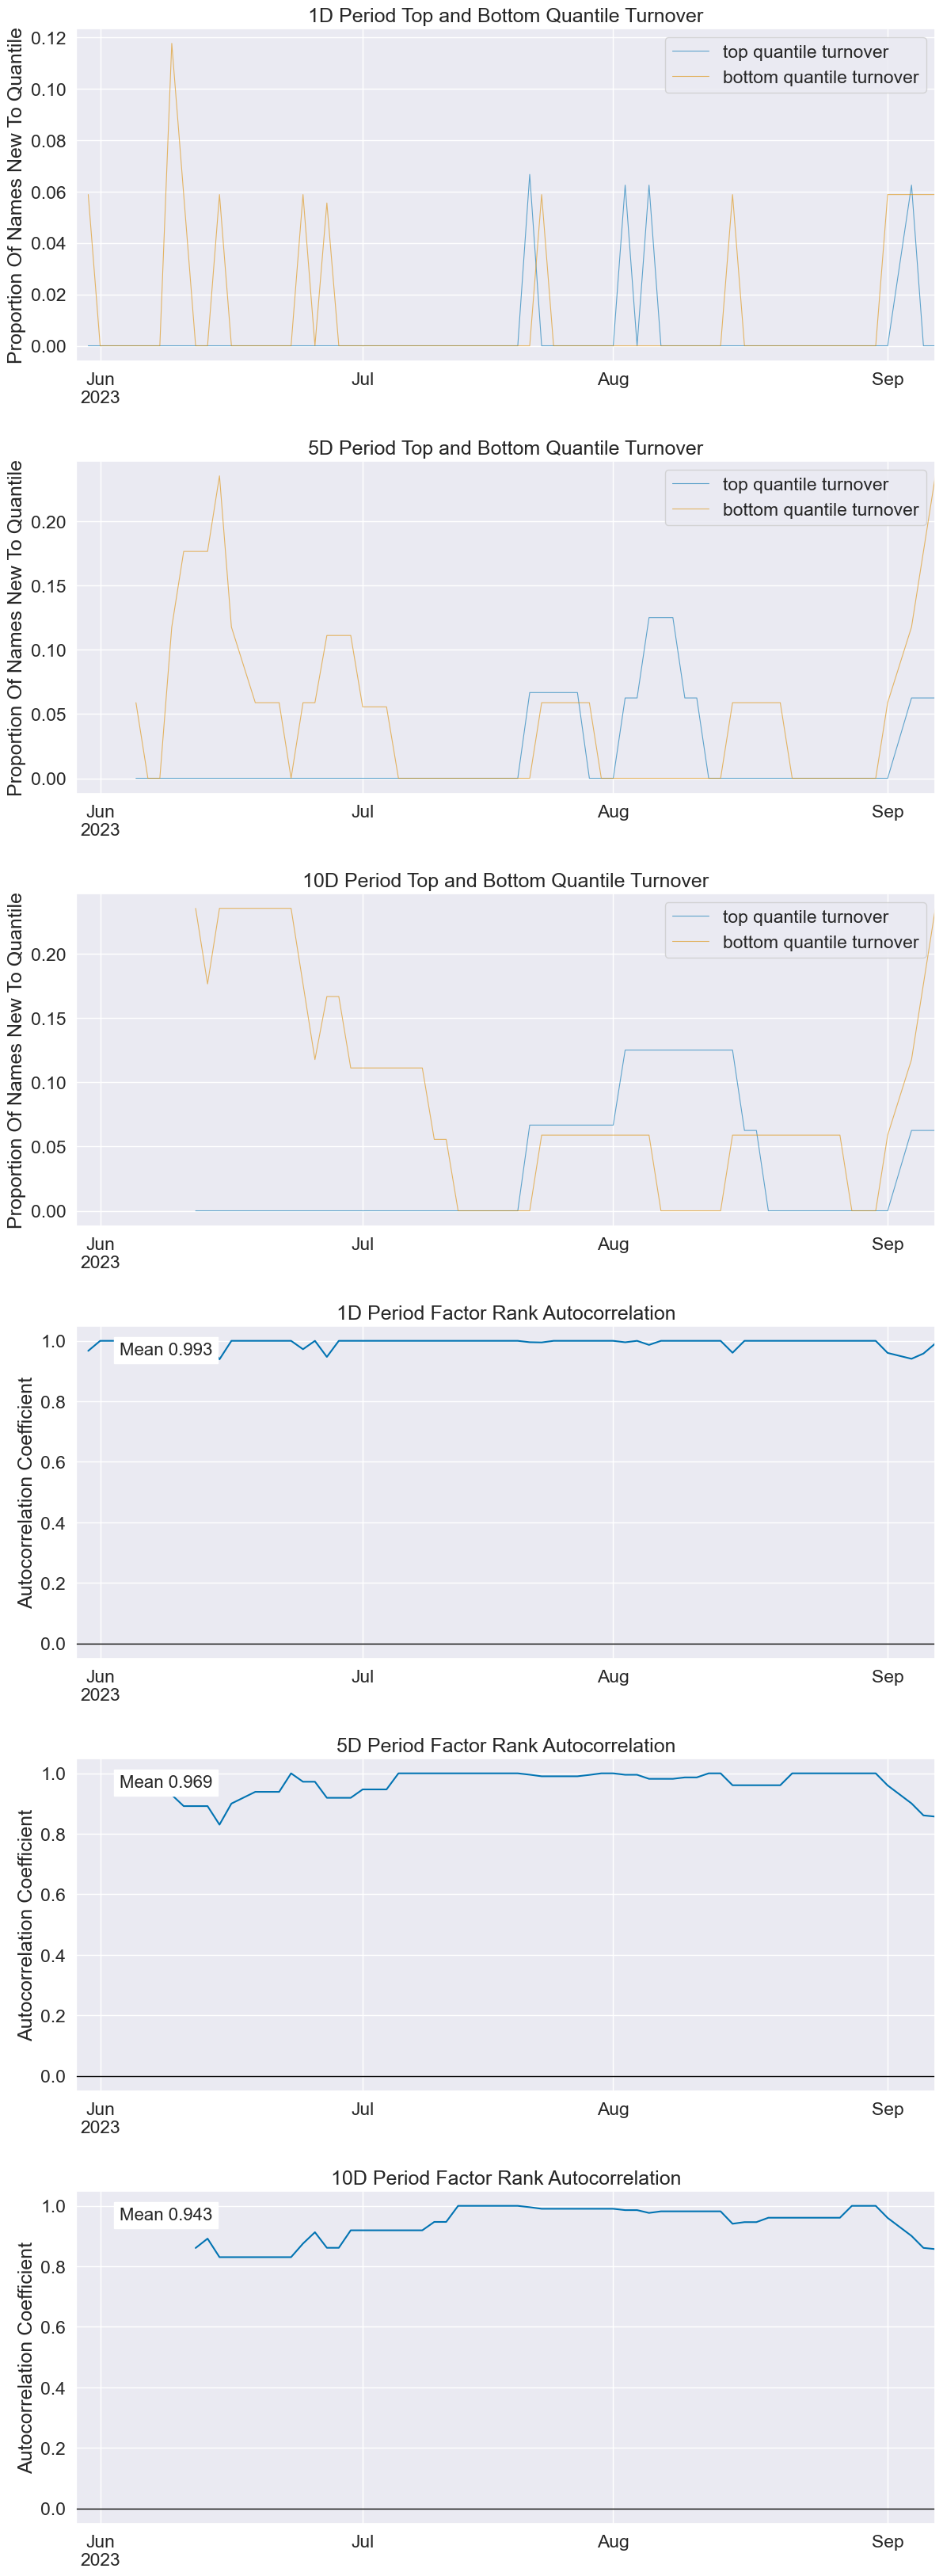

In [77]:
factor_data = al.utils.get_clean_factor_and_forward_returns(
    factor=merged_data['sentiment_score'],
    prices=prices,
    periods=(1,5,10),
    quantiles= 5,
    bins=None,
    max_loss=0.73
)

factor_data

al.tears.create_summary_tear_sheet(factor_data)

al.tears.create_full_tear_sheet(factor_data)



### Short Long Portfolio Return

,1D,5D,10D
date,,,
2023-05-30 00:00:00+00:00,-0.141707,-0.042633,0.010633
2023-05-31 00:00:00+00:00,-0.004644,0.010206,-0.055711
2023-06-01 00:00:00+00:00,0.092402,0.003648,-0.062655
2023-06-02 00:00:00+00:00,-0.273762,-0.129863,-0.072612
2023-06-05 00:00:00+00:00,0.090397,0.039954,-0.022973
...,...,...,...
2023-08-31 00:00:00+00:00,0.200186,-0.021639,0.199485
2023-09-01 00:00:00+00:00,-0.036434,-0.192022,0.124723
2023-09-05 00:00:00+00:00,-0.160604,0.112804,0.099214


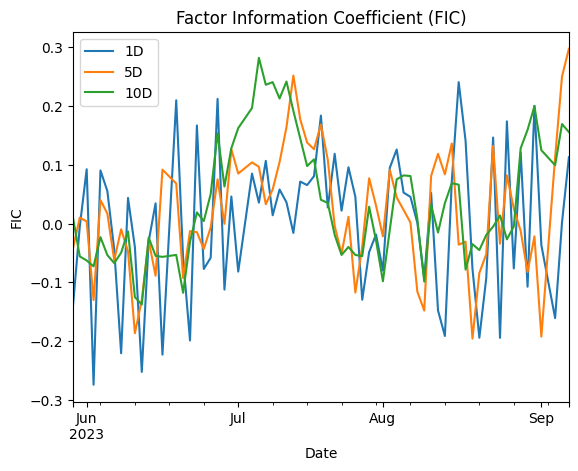

In [78]:
sharpe_ratio = al.performance.factor_information_coefficient(factor_data)
display(sharpe_ratio)
sharpe_ratio.plot()
plt.title("Factor Information Coefficient (FIC)")
plt.ylabel("FIC")
plt.xlabel("Date")
plt.show()